In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import sklearn.utils
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
test_final_100k_ = pd.read_csv('Datos/test_final_100k.csv')

# Pre procesamiento de los datos


## Postulantes

In [3]:
postulantes_educacion_desde_15_Abril = pd.read_csv('Datos/Fiuba_desde_15_Abril/fiuba_1_postulantes_educacion.csv')
postulantes_genero_y_edad_desde_15_Abril = pd.read_csv('Datos/Fiuba_desde_15_Abril/fiuba_2_postulantes_genero_y_edad.csv')
postulantes_educacion_hasta_15_abril = pd.read_csv('Datos/fiuba_hasta_15_abril/fiuba_1_postulantes_educacion.csv')
postulantes_genero_y_edad_hasta_15_abril = pd.read_csv('Datos/fiuba_hasta_15_abril/fiuba_2_postulantes_genero_y_edad.csv')
postulantes_educacion_original = pd.read_csv('Datos/datos_navent_fiuba/fiuba_1_postulantes_educacion.csv')
postulantes_genero_y_edad_original = pd.read_csv('Datos/datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv')

In [4]:
#Concateno datos de los tres sets y filtro postulantes repetidos

postulantes_genero_y_edad = pd.concat([postulantes_genero_y_edad_desde_15_Abril,postulantes_genero_y_edad_hasta_15_abril,postulantes_genero_y_edad_original], axis=0)
postulantes_genero_y_edad = postulantes_genero_y_edad.drop_duplicates('idpostulante')

postulantes_educacion = pd.concat([postulantes_educacion_desde_15_Abril,postulantes_educacion_hasta_15_abril,postulantes_educacion_original], axis=0)
postulantes_educacion = postulantes_educacion.drop_duplicates('idpostulante')

In [5]:
#Renombro las columnas a un nombre más apropiado

postulantes_educacion = postulantes_educacion.rename(columns={"nombre":"educacion"})

In [6]:
#Hay algun dato nulo?

postulantes_educacion.isnull().any()

idpostulante    False
educacion       False
estado          False
dtype: bool

In [7]:
postulantes_educacion.estado.value_counts()

Graduado      257355
En Curso      169975
Abandonado     20579
Name: estado, dtype: int64

In [8]:
#Para cada postulante, me interesa quedarme solamente con la mayor de sus educaciones
#Codifico variables categóricas en forma numérica para que luego puedan procesarlas los algoritmos.

postulantes_educacion['Cod_edu'] = np.array([1 if e == 'Secundario' else 
                                             2 if e == 'Otro' else 
                                             3 if e == 'Terciario/Técnico' else 
                                             4 if e == 'Universitario' else 
                                             5 if e == 'Posgrado' else 
                                             6 if e == 'Master' else 7 for e in postulantes_educacion.educacion])

postulantes_educacion['Cod_est'] = np.array([1 if e == 'Abandonado' else 
                                             2 if e == 'En curso' else 3 for e in postulantes_educacion.estado])

postulantes_educacion = postulantes_educacion.sort_values(['idpostulante','Cod_edu'], ascending = False).drop_duplicates('idpostulante')

In [9]:
postulantes_educacion.head()

,idpostulante,educacion,estado,Cod_edu,Cod_est
53092,zvxzzL6,Secundario,Graduado,1,3
118722,zvxzvD5,Terciario/Técnico,En Curso,3,3
60153,zvxzrWm,Otro,Graduado,2,3
50863,zvxzmED,Secundario,Graduado,1,3
211836,zvxzjoK,Terciario/Técnico,En Curso,3,3


In [10]:
#Reemplazo los valores en sexo que estan en 0.0 por NO_DECLARA

postulantes_genero_y_edad['sexo'] = postulantes_genero_y_edad['sexo'].replace({'0.0':'NO_DECLARA'})

In [11]:
#postulantes_genero_y_edad['Cod_sexo'] = np.array([0 if e == 'MASC' else 1 for e in postulantes_genero_y_edad.sexo])
postulantes_genero_y_edad = pd.get_dummies(postulantes_genero_y_edad, columns=['sexo'])
postulantes_genero_y_edad.head()

,idpostulante,fechanacimiento,sexo_FEM,sexo_MASC,sexo_NO_DECLARA
0,6MM,1985-01-01,0,1,0
1,ZX1,NaN,0,0,1
2,YZP,1961-05-01,0,1,0
3,ebE,1952-07-07,0,1,0
4,N1x,NaN,0,0,1


In [12]:
#Ojo, fechas de nacimiento nulas

postulantes_genero_y_edad.isnull().any()

idpostulante       False
fechanacimiento     True
sexo_FEM           False
sexo_MASC          False
sexo_NO_DECLARA    False
dtype: bool

In [13]:
#Convierto la columna fechanacimiento a formato datetime. 

postulantes_genero_y_edad['fechanacimiento'] = pd.to_datetime(postulantes_genero_y_edad['fechanacimiento'], errors='coerce')

In [14]:
#Corregir estas fechas nulas

postulantes_genero_y_edad.loc[postulantes_genero_y_edad.fechanacimiento.isnull()].head()

,idpostulante,fechanacimiento,sexo_FEM,sexo_MASC,sexo_NO_DECLARA
1,ZX1,NaT,0,0,1
4,N1x,NaT,0,0,1
5,8mW,NaT,0,0,1
6,52aw,NaT,0,0,1
8,a6OE,NaT,0,0,1


In [15]:
#Vamos ahora a agregar una columna adicional al dataframe, de modo que podamos observar la edad de cada persona

postulantes_genero_y_edad['edad'] = ((pd.datetime.today() - postulantes_genero_y_edad['fechanacimiento']).dt.days/365)
postulantes_genero_y_edad['edad'] = postulantes_genero_y_edad['edad'].fillna(0)
postulantes_genero_y_edad['edad'] = postulantes_genero_y_edad['edad'].astype(int)
postulantes_genero_y_edad.head(10)

,idpostulante,fechanacimiento,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,edad
0,6MM,1985-01-01,0,1,0,33
1,ZX1,NaT,0,0,1,0
2,YZP,1961-05-01,0,1,0,57
3,ebE,1952-07-07,0,1,0,65
4,N1x,NaT,0,0,1,0
5,8mW,NaT,0,0,1,0
6,52aw,NaT,0,0,1,0
7,NAjM,1962-06-09,1,0,0,56
8,a6OE,NaT,0,0,1,0
9,ZjlZ,1970-01-25,0,1,0,48


In [16]:
#Reviso la edad de las personas que cumplen años el 29/02

postulantes_nacidos_en_febrero = postulantes_genero_y_edad.loc[postulantes_genero_y_edad['fechanacimiento'].dt.month == 2]
postulantes_nacidos_en_febrero.loc[postulantes_nacidos_en_febrero['fechanacimiento'].dt.day == 29].sort_values('fechanacimiento',ascending = False).head(10)

,idpostulante,fechanacimiento,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,edad
232070,EzeN2Q4,2000-02-29,1,0,0,18
213258,96XkKlw,2000-02-29,1,0,0,18
297009,JBraa0E,2000-02-29,0,1,0,18
259430,ekOwAWW,2000-02-29,1,0,0,18
13782,VNr1dej,2000-02-29,0,1,0,18
176574,1QP82xR,2000-02-29,1,0,0,18
165756,Yj5p1GX,2000-02-29,0,1,0,18
186798,Bm5dkzR,2000-02-29,0,1,0,18
194211,3NP3dAJ,2000-02-29,1,0,0,18
197120,6rP38R3,2000-02-29,1,0,0,18


In [17]:
#Merge de los datos de los postulantes

postulantes = pd.merge(postulantes_genero_y_edad,postulantes_educacion,how='left',on='idpostulante')
postulantes['educacion'] = postulantes['educacion'].fillna('Ninguna')
postulantes['estado'] = postulantes['estado'].fillna('Ninguno')
postulantes['Cod_est'] = postulantes['Cod_est'].fillna('0')
postulantes['Cod_edu'] = postulantes['Cod_edu'].fillna('0')
postulantes = postulantes.drop(['fechanacimiento'],axis=1)
postulantes.head()

,idpostulante,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,edad,educacion,estado,Cod_edu,Cod_est
0,6MM,0,1,0,33,Ninguna,Ninguno,0,0
1,ZX1,0,0,1,0,Ninguna,Ninguno,0,0
2,YZP,0,1,0,57,Master,En Curso,6,3
3,ebE,0,1,0,65,Universitario,Graduado,4,3
4,N1x,0,0,1,0,Ninguna,Ninguno,0,0


In [18]:
postulantes.isnull().any()

idpostulante       False
sexo_FEM           False
sexo_MASC          False
sexo_NO_DECLARA    False
edad               False
educacion          False
estado             False
Cod_edu            False
Cod_est            False
dtype: bool

## Vistas

In [19]:
#vistas = pd.read_csv('Datos/fiuba_hasta_15_abril/fiuba_3_vistas.csv')

In [20]:
#Vistazo a la estructura del dataframe

#vistas.head()

In [21]:
#El dataframe posee 5758686 registros

#vistas.shape

In [22]:
#No tenemos registros nulos

#vistas.isnull().any()

In [23]:
#En este dataframe tenemos 11223 avisos únicos 

#vistas['idAviso'].value_counts().size

In [24]:
#Y de los postulantes del dataset, 272526 han visto al menos un aviso

#vistas['idpostulante'].value_counts().size

In [25]:
#Modifico el nombre de la columna timestamp y en su lugar pongo un nombre más descriptivo.>

#vistas = vistas.rename(columns = {'timestamp':'fechahoravisualizacion'})

In [26]:
#Ordeno la informacion sobre la fecha y hora de visualizaciones, modificando su formato y agregando columnas que me permitan
#analizar de forma individual la fecha y la hora.

#vistas['fechahoravisualizacion'] = pd.to_datetime(vistas['fechahoravisualizacion'])
#vistas['fechavisualizacion'] = vistas['fechahoravisualizacion'].dt.date
#vistas['horavisualizacion'] = vistas['fechahoravisualizacion'].dt.time
#vistas.sort_values('fechavisualizacion').head(10)

# Avisos

In [27]:
avisos_detalle_desde_15_Abril = pd.read_csv('Datos/Fiuba_desde_15_Abril/fiuba_6_avisos_detalle.csv')
avisos_online_hasta_15_abril = pd.read_csv('Datos/fiuba_hasta_15_abril/fiuba_5_avisos_online.csv')
avisos_detalle_hasta_15_abril = pd.read_csv('Datos/fiuba_hasta_15_abril/fiuba_6_avisos_detalle.csv')
avisos_online_original = pd.read_csv('Datos/datos_navent_fiuba/fiuba_5_avisos_online.csv')
avisos_detalle_original = pd.read_csv('Datos/datos_navent_fiuba/fiuba_6_avisos_detalle.csv')
avisos_detalle2 = pd.read_csv('fiuba_6_avisos_detalle_missing_nivel_laboral.csv')

In [28]:
avisos_detalle = pd.concat([avisos_detalle2,avisos_detalle_desde_15_Abril,avisos_detalle_hasta_15_abril,avisos_detalle_original],axis=0).drop_duplicates('idaviso')
avisos_online = pd.concat([avisos_online_hasta_15_abril,avisos_online_original],axis=0).drop_duplicates('idaviso')

In [29]:
avisos_online.shape

(9430, 1)

In [30]:
avisos_detalle.shape

(25288, 11)

In [31]:
#No hay registros nulos

avisos_online.isnull().any()

idaviso    False
dtype: bool

In [32]:
avisos_detalle.isnull().any()

idaviso                 False
idpais                  False
titulo                  False
descripcion             False
nombre_zona             False
ciudad                   True
mapacalle                True
tipo_de_trabajo         False
nivel_laboral            True
nombre_area             False
denominacion_empresa     True
dtype: bool

## Postulaciones

In [33]:
postulaciones_hasta_15_abril = pd.read_csv('Datos/fiuba_hasta_15_abril/fiuba_4_postulaciones.csv')
postulaciones_original = pd.read_csv('Datos/datos_navent_fiuba/fiuba_4_postulaciones.csv')

In [34]:
#Concateno datos de todos los sets y filtro repetidos

postulaciones = pd.concat([postulaciones_hasta_15_abril,postulaciones_original],axis=0).drop_duplicates()

In [35]:
#Vistazo a la estructura del dataframe

postulaciones.head()

,idaviso,idpostulante,fechapostulacion
0,1112248724,NjlD,2018-01-19 07:39:16
1,1112286523,ZaO5,2018-01-24 15:07:39
2,1112272060,ZaO5,2018-01-24 15:20:10
3,1112288401,ZaO5,2018-01-26 08:37:04
4,1112300563,ZaO5,2018-01-30 13:35:48


In [36]:
#Tenemos 6604534 registros

postulaciones.shape

(6604534, 3)

In [37]:
#No hay registros nulos

postulaciones.isnull().any()

idaviso             False
idpostulante        False
fechapostulacion    False
dtype: bool

In [38]:
#Todas las postulaciones historicas

postulantes = postulantes.drop(['educacion','estado'],axis=1)
postulaciones_historico = pd.merge(postulantes,postulaciones[['idaviso','idpostulante']],on='idpostulante',how='inner')

In [39]:
#Agrego label para indicar si se postulo o no, en este caso todos se postularon

postulaciones_historico['sepostulo'] = 1
postulaciones_historico.head()

,idpostulante,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,edad,Cod_edu,Cod_est,idaviso,sepostulo
0,aEW8J,1,0,0,53,4,3,1112226306,1
1,aEW8J,1,0,0,53,4,3,1112028437,1
2,aEW8J,1,0,0,53,4,3,1112263553,1
3,aEW8J,1,0,0,53,4,3,1112262301,1
4,aEW8J,1,0,0,53,4,3,1112280883,1


In [40]:
#Ya tengo los casos de postulaciones que se realizaron. Necesito ahora fabricarme casos de postulaciones que no se
#hayan realizado para entrenar el modelo

#Aumento la cantidad de datos de avisos_detalle para que coincida con el largo de postulantes
avisos_detalle = avisos_detalle.idaviso
while len (avisos_detalle) < 504407:
    avisos_detalle = pd.concat([avisos_detalle,avisos_detalle],axis=0)
    
avisos_detalle = avisos_detalle.reset_index().drop('index',axis=1)

#Mezclo las filas para que no sigan un patrón.
avisos_detalle = sklearn.utils.shuffle(avisos_detalle)

In [41]:
#Junto con el dataframe de postulantes y descarto el exceso

avisos_y_postulantes = pd.concat([postulantes,avisos_detalle],axis=1).dropna(axis=0,how='any')
avisos_y_postulantes.head()

,idpostulante,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,edad,Cod_edu,Cod_est,idaviso
0,6MM,0.0,1.0,0.0,33.0,0,0,1001284385
1,ZX1,0.0,0.0,1.0,0.0,0,0,1110092955
2,YZP,0.0,1.0,0.0,57.0,6,3,1110092958
3,ebE,0.0,1.0,0.0,65.0,4,3,1110391074
4,N1x,0.0,0.0,1.0,0.0,0,0,1110669632


In [42]:
#Descarto los casos que casualmente se corresponden a postulaciones que sí sucedieron. Ahora estoy seguro de que
#las combinaciones postulante-aviso de este dataframe nunca ocurrieron

avisos_y_postulantes = avisos_y_postulantes.drop(pd.merge(avisos_y_postulantes,postulaciones,how='inner',on=['idpostulante','idaviso']).index,axis=0)

#Agrego el label correspondiente

avisos_y_postulantes['sepostulo'] = 0

In [43]:
#Junto todo

Data = pd.concat ([postulaciones_historico,avisos_y_postulantes],axis=0)
Data.head()

,idpostulante,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,edad,Cod_edu,Cod_est,idaviso,sepostulo
0,aEW8J,1.0,0.0,0.0,53.0,4,3,1112226306,1
1,aEW8J,1.0,0.0,0.0,53.0,4,3,1112028437,1
2,aEW8J,1.0,0.0,0.0,53.0,4,3,1112263553,1
3,aEW8J,1.0,0.0,0.0,53.0,4,3,1112262301,1
4,aEW8J,1.0,0.0,0.0,53.0,4,3,1112280883,1


In [44]:
#Filtro los registros que están presentes en test_final_100k_

Data = Data.set_index(['idpostulante','idaviso']).drop(test_final_100k_.set_index(['idpostulante','idaviso']).index).reset_index()

# Árbol de decisión

In [45]:
#Acá tengo la totalidad de los datos recolectados y sus labels correspondientes.
Data = sklearn.utils.shuffle(Data)
x_train_complete = Data.drop(['idpostulante','sepostulo'], axis=1).values 
y_train_complete = Data['sepostulo']

x_train, x_test, y_train, y_test = train_test_split(x_train_complete, y_train_complete, test_size = 0.25, random_state = 0)


#De los datos completos me reservo una parte (10%) para probar al árbol luego de haberlo entrenado.
#x_train = x_train_complete[0:6366776]
#y_train = y_train_complete[0:6366776]

#x_test = x_train_complete[6366776:7074196]
#y_test = y_train_complete[6366776:7074196]

#Estos son los datos de test_final_100k_ pasados a formato vector. 
#Con estos datos voy a sacar los resultados para llenar el csv del submit.
x_query = pd.merge(test_final_100k_,postulantes,on='idpostulante',how='inner').drop(['idpostulante','id'],axis=1).values


In [46]:
#Creo un árbol 
arbol = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 5)

#Lo entreno con la porción de los datos destinada a tal fin 
arbol = arbol.fit(x_train, y_train)

In [47]:
#Pruebo contra el set de prueba para ver con cuanta precision puede pedecir el árbol.

precision = round(arbol.score(x_test, y_test) * 100, 2)
print(precision)

93.75


In [48]:
probabilidades=[]
for x in x_query:
    y_pred=arbol.predict([x])
    #print("Prediccion: " + str(y_pred))
    y_proba=arbol.predict_proba([x])
    #print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")
    probabilidades.append(y_proba[0][1])

In [109]:
A=pd.concat([test_final_100k_,pd.DataFrame(probabilidades)],axis=1)

In [129]:
A[['id',0]].to_csv('Datos/res.csv')

In [ ]:
#cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
#accuracies = list()
#max_attributes = len(list(Data))
#depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
#for depth in depth_range:
#    fold_accuracy = []
#    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
#                                             min_samples_split=20,
#                                             min_samples_leaf=5,
#                                             max_depth = depth)
#    for train_fold, valid_fold in cv.split(Data):
#        #f_train = Data.loc[train_fold]
#        #f_valid = Data.loc[valid_fold] 
#        f_train.loc[f_train.index.intersection(train_fold)].reindex(train_fold)
#        f_valid.loc[f_valid.index.intersection(valid_fold)].reindex(valid_fold)
#
#        model = tree_model.fit(X = f_train.drop(['idpostulante','sepostulo','idaviso'], axis=1), 
#                               y = f_train['sepostulo']) 
#        valid_acc = model.score(X = f_valid.drop(['idpostulante','sepostulo','idaviso'], axis=1), 
#                                y = f_valid['sepostulo']) # calculamos la precision con el segmento de validacion
#        fold_accuracy.append(valid_acc)
#
#    avg = sum(fold_accuracy)/len(fold_accuracy)
#    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
#df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
#df = df[["Max Depth", "Average Accuracy"]]
#print(df.to_string(index=False))

## Random Forest

In [166]:
from sklearn.ensemble import RandomForestClassifier

rfClas = RandomForestClassifier(n_estimators = 25, min_samples_split=20,min_samples_leaf=5,max_depth = 5)
rfClas.fit(x_train, y_train);

print("Precision Random Forest Classifier:",round(rfClas.score(x_test, y_test) * 100, 2),"%")

Precision Random Forest Classifier: 93.72 %


In [167]:
from sklearn.ensemble import RandomForestRegressor

rfReg = RandomForestRegressor(n_estimators = 50, min_samples_split=20,min_samples_leaf=5,max_depth = 5)
rfReg.fit(x_train, y_train);

print("Precision Random Forest Regressor:",round(rfReg.score(x_test, y_test) * 100, 2),"%")

Precision Random Forest Regressor: 14.71 %


## KNN

In [176]:
#k= 1  Precision KNN: 92.68 %
#k= 3  Precision KNN: 94.49 %
#k= 5  Precision KNN: 94.78 %
#k= 7  Precision KNN: 94.86 %
#k= 9  Precision KNN: 94.88 %
#k= 11  Precision KNN: 94.89 %
#k= 13  Precision KNN: 94.88 %
#k= 15  Precision KNN: 94.88 %

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors=7)
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [178]:
print(" Precision KNN con K=7:",round(model.score(x_test, y_test) * 100, 2),"%")

 Precision KNN con K=7: 94.86 %


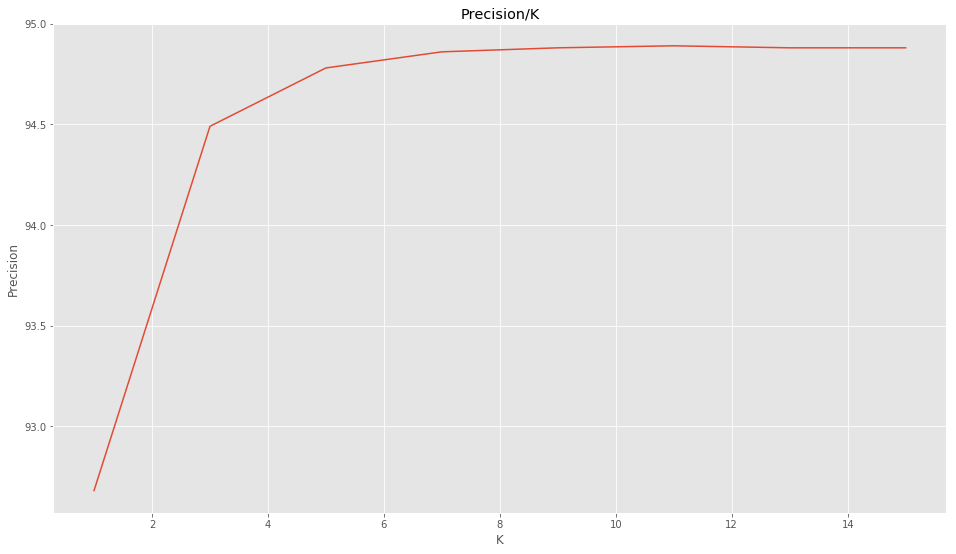

In [177]:
plt.plot([1,3,5,7,9,11,13,15],[92.68,94.49,94.78,94.86,94.88,94.89,94.88,94.88])
plt.ylabel('Precision')
plt.xlabel('K')
plt.title('Precision/K')
plt.show()

## Naive Bayes

In [181]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train,y_train)

print("Precision Naive Bayes:",round(nb.score(x_test, y_test) * 100, 2),"%")

Precision Naive Bayes: 92.66 %


## Gradient Boosting

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=25, min_samples_split=20, min_samples_leaf=5, max_depth=5)
gb.fit(x_train,y_train)

print("Precision Gradient Boosting:",round(gb.score(x_test, y_test) * 100, 2),"%")

Precision Gradient Boosting: 93.77 %


## XGBoost

In [81]:
from xgboost import XGBClassifier

xgboost = XGBClassifier()
xgboost.fit(x_train,y_train)

print("Precision XGBoost:",round(xgboost.score(x_test, y_test) * 100, 2),"%")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Precision XGBoost: 93.62 %
